# ======================================
# SIMULACIÓN A LAZO ABIERTO - DOBLE PÉNDULO
# ======================================

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
if not hasattr(np, "disp"):
    np.disp = lambda x: print(x)
import roboticstoolbox as rtb
from spatialmath import SE3

# Se define el modelo del doble péndulo

El péndulo está compuesto dos eslabones tal como se muestra en la siguiente figura. La gravedad apunta constantemente en el sentido contrario a $Y_0$

En la definición del modelo se introducen los datos provistos en el enunciado, pero tambien los parámetros del rozamiento 

In [2]:
if not hasattr(np, "disp"):
    np.disp = lambda x: print(x)
import roboticstoolbox as rtb
from spatialmath import SE3

dp = rtb.DHRobot(
    [
        rtb.RevoluteDH(a=0.2,m=1.5,
            r=np.array([-0.1, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,1e-3]),
            B=0.002, N=100),
        rtb.RevoluteDH(a=0.2,m=1,
            r=np.array([-0.1, 0, 0]),
            I=np.array([0,0,0,0,0,0,0,0,1e-4]),
            B=0.002, N=100)
    ],
    gravity = np.array([0, -9.81, 0]), # Ojo con el signo, la gravedad va hacia abajo con signo positivo
    name="dp")

print(dp)
print(dp.dynamics())

DHRobot: dp, 2 joints (RR), dynamics, standard DH parameters
┌─────┬────┬─────┬──────┐
│ θⱼ  │ dⱼ │ aⱼ  │  ⍺ⱼ  │
├─────┼────┼─────┼──────┤
│  q1 │  0 │ 0.2 │ 0.0° │
│  q2 │  0 │ 0.2 │ 0.0° │
└─────┴────┴─────┴──────┘

┌──┬──┐
└──┴──┘

┌───────┬──────┬──────────────┬─────────────────────────────┬────┬────────┬────────┬────┐
│   j   │  m   │      r       │              I              │ Jm │   B    │   Tc   │ G  │
├───────┼──────┼──────────────┼─────────────────────────────┼────┼────────┼────────┼────┤
│ link1 │  1.5 │ -0.1,  0,  0 │  0,  0,  0.001,  0,  0,  0  │  0 │  0.002 │  0,  0 │  0 │
│ link2 │  1   │ -0.1,  0,  0 │  0,  0,  0.0001,  0,  0,  0 │  0 │  0.002 │  0,  0 │  0 │
└───────┴──────┴──────────────┴─────────────────────────────┴────┴────────┴────────┴────┘

None


In [19]:
# from scipy.integrate import solve_ivp

# # def dynamics(t, y, use_coulomb=False, Fc=None, k_smooth=50.0):
# #     """
# #     Dinámica del doble péndulo con opción de fricción viscosa, motriz reflejada y Coulomb (opcional).

# #     use_coulomb : bool -> Si True, añade fricción de Coulomb suavizada.
# #     Fc          : np.array -> Coeficientes de fricción Coulomb [N·m].
# #     k_smooth    : float -> Factor de suavizado para tanh().
# #     """
# #     n = dp.n
# #     q = y[:n]
# #     qd = y[n:]

# #     tau = np.zeros(n)
# #     M = dp.inertia(q)
# #     C = dp.coriolis(q, qd)
# #     G = dp.gravload(q)

# #     # --- Fricción viscosa en la articulación (ya efectiva) ---
# #     B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
# #     tau_visc = B_vec * qd

# #     # --- Fricción de Coulomb opcional (suavizada) ---
# #     if use_coulomb:
# #         if Fc is None:
# #             Fc = np.zeros(n)
# #         tau_coul = Fc * np.tanh(k_smooth * qd)
# #     else:
# #         tau_coul = np.zeros(n)

# #     tau_fric = tau_visc + tau_coul

# #     # --- Dinámica final ---
# #     qdd = np.linalg.solve(M, tau - C @ qd - G - tau_fric)

# #     return np.concatenate((qd, qdd))

# # --- Dinámica completa (no lineal, acoplada) ---
# def dynamics_nonlinear(t, y, use_coulomb=False, Fc=None, k_smooth=50.0):
#     """
#     Modelo dinámico completo del doble péndulo con reductores.
#     Incluye efectos de M(q), C(q, qd), G(q), fricción viscosa y opcionalmente Coulomb.
#     """
#     n = dp.n
#     q = y[:n]
#     qd = y[n:]
#     tau_m = np.zeros(n)  # torque motor (entrada), lazo abierto

#     # --- Parámetros de cada articulación ---
#     N_vec = np.array([getattr(link, 'N', 1.0) for link in dp.links])   # relación de reducción
#     B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])   # fricción viscosa eje
#     Jm_vec = np.zeros(n)  # si se conoce la inercia del motor, definir aquí

#     # --- Dinámica del robot ---
#     M = dp.inertia(q)
#     C = dp.coriolis(q, qd)
#     G = dp.gravload(q)

#     # --- Fricción viscosa y de Coulomb ---
#     tau_visc = B_vec * (N_vec**2) * qd

#     if use_coulomb:
#         if Fc is None:
#             Fc = np.zeros(n)
#         tau_coul = Fc * N_vec * np.tanh(k_smooth * qd)
#     else:
#         tau_coul = np.zeros(n)

#     tau_fric = tau_visc + tau_coul

#     # --- Ecuación completa ---
#     # N * τ_m = Jm * N^2 * qdd + B * N^2 * qd + F_r * N * sign(qd) + M * qdd + C * qd + G
#     # -> agrupamos en torno a qdd:
#     M_eff = M + np.diag(Jm_vec * N_vec**2)
#     rhs = N_vec * tau_m - C @ qd - G - tau_fric
#     qdd = np.linalg.solve(M_eff, rhs)

#     return np.concatenate((qd, qdd))


# def dynamics_lineal(t, y, use_coulomb=False, Fc=None, k_smooth=50.0):
#     """
#     Dinámica lineal desacoplada del doble péndulo (modelo simplificado).

#     Ecuación vectorial:
#         N τ_m = (J_m N² + M̄) q̈ + B N² q̇ + τ_p
#     con τ_p = C(q,q̇) q̇ + G(q)

#     use_coulomb : bool -> Si True, añade fricción de Coulomb suavizada.
#     Fc          : np.array -> Coeficientes de fricción Coulomb [N·m].
#     k_smooth    : float -> Factor de suavizado para tanh().
#     """
#     n = dp.n
#     q = y[:n]
#     qd = y[n:]

#     # --- Torques motores (por ahora lazo abierto) ---
#     tau_m = np.zeros(n)

#     # --- Parámetros de cada articulación ---
#     N_vec = np.array([getattr(link, 'N', 1.0) for link in dp.links])
#     B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
#     Jm_vec = np.zeros(n)  # si no se conocen, se asume 0

#     # --- Dinámica del robot (solo para τ_p) ---
#     M = dp.inertia(q)
#     C = dp.coriolis(q, qd)
#     G = dp.gravload(q)
#     tau_p = C @ qd + G  # efectos del péndulo

#     # --- Inercia equivalente M̄ (diagonal de M) ---
#     M_bar = np.diag(M)

#     # --- Fricción viscosa reflejada por N² ---
#     tau_visc = B_vec * (N_vec ** 2) * qd

#     # --- Fricción de Coulomb opcional (suavizada) ---
#     if use_coulomb:
#         if Fc is None:
#             Fc = np.zeros(n)
#         tau_coul = Fc * np.tanh(k_smooth * qd)
#     else:
#         tau_coul = np.zeros(n)

#     tau_fric = tau_visc + tau_coul

#     # --- Cálculo de aceleraciones (modelo lineal vectorial) ---
#     denom = Jm_vec * (N_vec ** 2) + M_bar  # (J_m N² + M̄)
#     numer = N_vec * tau_m - B_vec * (N_vec ** 2) * qd - tau_p - tau_coul
#     qdd = numer / denom

#     return np.concatenate((qd, qdd))



# # --- Condiciones iniciales ---
# # Brazo arriba de todo
# q0 = [np.pi/2, 0.0]
# qd0 = [0.0001, 0.0001]
# y0 = np.concatenate((q0, qd0))

# # Brazo abajo con pequeño angulo así va lento y cae con la gravedad
# q1 = [np.pi/8, 0.0]
# qd1 = [0.0, 0.0]
# y1 = np.concatenate((q1, qd1))


# # Brazo a 90 grados así cae con la gravedad rapidamente
# q2 = [np.pi/4, 0.0]
# qd2 = [0.0, 0.0]
# y2 = np.concatenate((q2, qd2))


# t_final = 5.0

# # # --- Integración ---
# # sol = solve_ivp(
# #     dynamics,
# #     [0, t_final],
# #     y0,
# #     method='RK45',
# #     t_eval=np.linspace(0, t_final, 1000),
# #     rtol=1e-4, atol=1e-6
# # )

# sol = solve_ivp(
#     lambda t, y: dynamics(t, y, use_coulomb=True, Fc=np.array([0.001, 0.001])),
#     [0, t_final], y0,
#     method='RK45', t_eval=np.linspace(0, t_final, 1000),
#     rtol=1e-4, atol=1e-6
# )

# t = sol.t
# q1, q2 = sol.y[0], sol.y[1]
# qd1, qd2 = sol.y[2], sol.y[3]


Modelo de la dinámica del sistema

$M(q)\ddot{q}=\tau−C(q,\dot{q}​)\dot{q}​−G(q)−(B_{joint})\dot{q}​−\tau_{c​oul}$


1. `dynamics_nonlinear(...)` → modelo completo no lineal acoplado
   (usa ( $M(q)$, $C(q, \dot q), G(q) )$ )
   basado en:

   $N K_t u = J_m N^2 \ddot q + B N^2 \dot q + F_r N \mathrm{sign}(\dot q) + M(q)\ddot q + C(q,\dot q)\dot q + G(q)$
   

2. `dynamics_linear(...)` → modelo lineal, SISO y desacoplado
   (hipótesis: $N \approx 100$, $(\dot q, \ddot q)$ pequeñas, pesos balanceados)
   basado en:

   $N \tau_m = (J_m N^2 + \overline{m})\ddot q + B N^2 \dot q + \tau_p$


In [20]:
def dynamics_nonlinear(t, y, use_coulomb=False, Fc=None, k_smooth=50.0):
    """
    Modelo dinámico completo del doble péndulo con reductores.
    Incluye efectos de M(q), C(q, qd), G(q), fricción viscosa y opcionalmente Coulomb.
    """
    n = dp.n
    q = y[:n]
    qd = y[n:]
    tau_m = np.zeros(n)  # torque motor (entrada), lazo abierto

    # --- Parámetros de cada articulación ---
    N_vec = np.array([getattr(link, 'N', 1.0) for link in dp.links])   # relación de reducción
    B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])   # fricción viscosa eje
    Jm_vec = np.zeros(n)  # si se conoce la inercia del motor, definir aquí

    # --- Dinámica del robot ---
    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)

    # --- Fricción viscosa y de Coulomb ---
    tau_visc = B_vec * (N_vec**2) * qd

    if use_coulomb:
        if Fc is None:
            Fc = np.zeros(n)
        tau_coul = Fc * N_vec * np.tanh(k_smooth * qd)
    else:
        tau_coul = np.zeros(n)

    tau_fric = tau_visc + tau_coul

    # --- Ecuación completa ---
    # N * τ_m = Jm * N^2 * qdd + B * N^2 * qd + F_r * N * sign(qd) + M * qdd + C * qd + G
    # -> agrupamos en torno a qdd:
    M_eff = M + np.diag(Jm_vec * N_vec**2)
    rhs = N_vec * tau_m - C @ qd - G - tau_fric
    qdd = np.linalg.solve(M_eff, rhs)

    return np.concatenate((qd, qdd))


def dynamics_lineal(t, y, use_coulomb=False, Fc=None, k_smooth=50.0):
    """
    Dinámica lineal desacoplada del doble péndulo (modelo simplificado).

    Ecuación vectorial:
        N τ_m = (J_m N² + M̄) q̈ + B N² q̇ + τ_p
    con τ_p = C(q,q̇) q̇ + G(q)

    use_coulomb : bool -> Si True, añade fricción de Coulomb suavizada.
    Fc          : np.array -> Coeficientes de fricción Coulomb [N·m].
    k_smooth    : float -> Factor de suavizado para tanh().
    """
    n = dp.n
    q = y[:n]
    qd = y[n:]

    # --- Torques motores (por ahora lazo abierto) ---
    tau_m = np.zeros(n)

    # --- Parámetros de cada articulación ---
    N_vec = np.array([getattr(link, 'N', 1.0) for link in dp.links])
    B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
    Jm_vec = np.zeros(n)  # si no se conocen, se asume 0

    # --- Dinámica del robot (solo para τ_p) ---
    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)
    tau_p = C @ qd + G  # efectos del péndulo

    # --- Inercia equivalente M̄ (diagonal de M) ---
    M_bar = np.diag(M)

    # --- Fricción viscosa reflejada por N² ---
    tau_visc = B_vec * (N_vec ** 2) * qd

    # --- Fricción de Coulomb opcional (suavizada) ---
    if use_coulomb:
        if Fc is None:
            Fc = np.zeros(n)
        tau_coul = Fc * np.tanh(k_smooth * qd)
    else:
        tau_coul = np.zeros(n)

    tau_fric = tau_visc + tau_coul

    # --- Cálculo de aceleraciones (modelo lineal vectorial) ---
    denom = Jm_vec * (N_vec ** 2) + M_bar  # (J_m N² + M̄)
    numer = N_vec * tau_m - B_vec * (N_vec ** 2) * qd - tau_p - tau_coul
    qdd = numer / denom

    return np.concatenate((qd, qdd))

Se hace una simulación del comportamiento de cada una de las plantas en tres casos de aplicación.

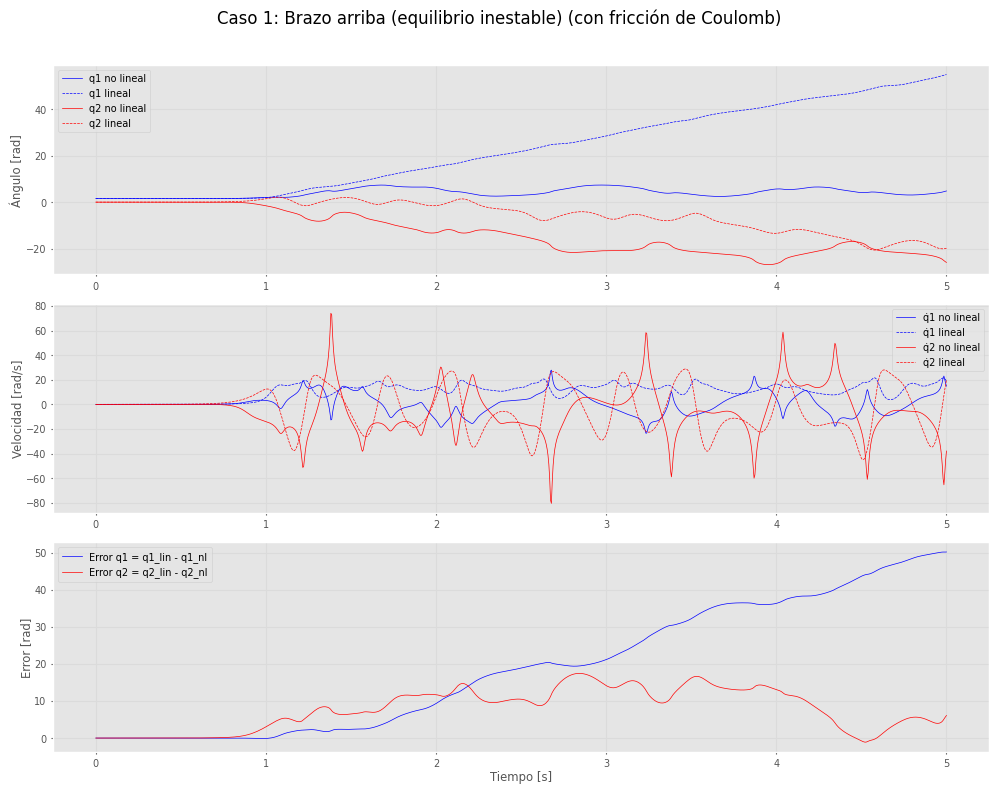

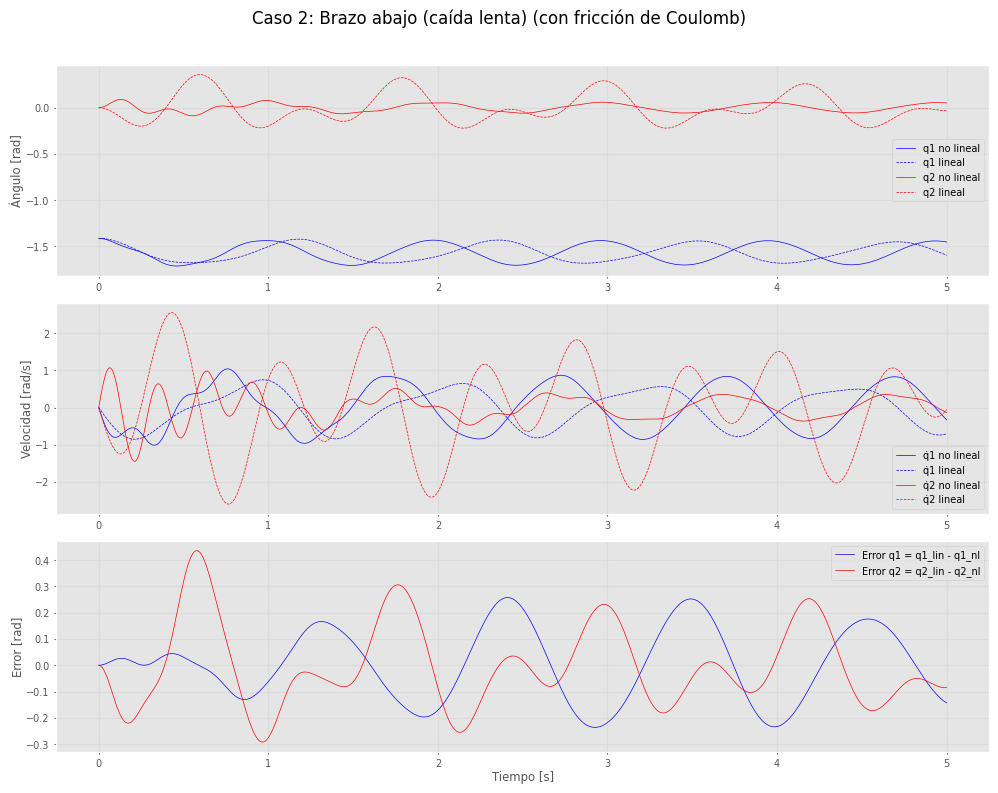

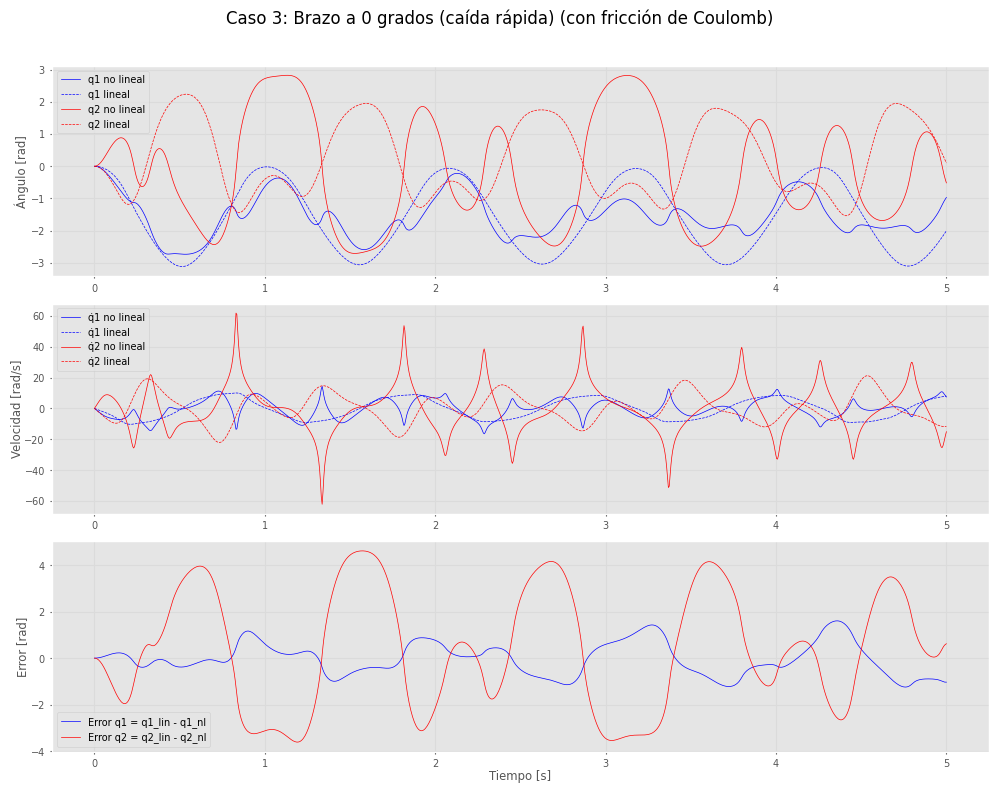

In [21]:
from scipy.integrate import solve_ivp

# --- Condiciones iniciales ---
cases = {
    "Caso 1: Brazo arriba (equilibrio inestable)": np.concatenate(([np.pi/2, 0.0], [0.001, 0.001])),
    "Caso 2: Brazo abajo (caída lenta)": np.concatenate(([-np.pi/2 + np.pi/20, 0.0], [0.0, 0.0])),
    "Caso 3: Brazo a 0 grados (caída rápida)": np.concatenate(([0.0, 0.0], [0.0, 0.0])),
}

t_final = 5.0
t_eval = np.linspace(0, t_final, 1000)

# --- Parámetro de fricción de Coulomb ---
Fc = np.array([0.001, 0.001])

# --- Función auxiliar para simular ambos modelos ---
def simulate_models(y0):
    sol_nonlin = solve_ivp(
        lambda t, y: dynamics_nonlinear(t, y, use_coulomb=True, Fc=Fc),
        [0, t_final],
        y0,
        t_eval=t_eval,
        rtol=1e-5, atol=1e-7
    )
    sol_lin = solve_ivp(
        lambda t, y: dynamics_lineal(t, y, use_coulomb=True, Fc=Fc),
        [0, t_final],
        y0,
        t_eval=t_eval,
        rtol=1e-5, atol=1e-7
    )
    return sol_nonlin, sol_lin

# --- Simular y graficar para cada caso ---
for title, y0 in cases.items():
    sol_nl, sol_lin = simulate_models(y0)
    
    # Extraer resultados
    t = sol_nl.t
    q_nl, qd_nl = sol_nl.y[0:2, :], sol_nl.y[2:4, :]
    q_lin, qd_lin = sol_lin.y[0:2, :], sol_lin.y[2:4, :]

    # Errores
    err_q = q_lin - q_nl
    err_qd = qd_lin - qd_nl

    # --- Gráficos ---
    plt.figure(figsize=(10, 8))
    plt.suptitle(title + " (con fricción de Coulomb)", fontsize=12)

    # 1️⃣ Ángulos
    plt.subplot(3, 1, 1)
    plt.plot(t, q_nl[0], 'b', label='q1 no lineal')
    plt.plot(t, q_lin[0], 'b--', label='q1 lineal')
    plt.plot(t, q_nl[1], 'r', label='q2 no lineal')
    plt.plot(t, q_lin[1], 'r--', label='q2 lineal')
    plt.ylabel('Ángulo [rad]')
    plt.legend(); plt.grid(True)

    # 2️⃣ Velocidades
    plt.subplot(3, 1, 2)
    plt.plot(t, qd_nl[0], 'b', label='q̇1 no lineal')
    plt.plot(t, qd_lin[0], 'b--', label='q̇1 lineal')
    plt.plot(t, qd_nl[1], 'r', label='q̇2 no lineal')
    plt.plot(t, qd_lin[1], 'r--', label='q̇2 lineal')
    plt.ylabel('Velocidad [rad/s]')
    plt.legend(); plt.grid(True)

    # 3️⃣ Errores (entre modelos)
    plt.subplot(3, 1, 3)
    plt.plot(t, err_q[0], 'b', label='Error q1 = q1_lin - q1_nl')
    plt.plot(t, err_q[1], 'r', label='Error q2 = q2_lin - q2_nl')
    plt.ylabel('Error [rad]')
    plt.xlabel('Tiempo [s]')
    plt.legend(); plt.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


Se pueden ver con los siguientes resultados de las simulaciones:

* En el *caso 1* cuando el péndulo está aproximadamente quieto el error es básicamente cero, pero en cambio cuando el péndulo cáe el comportamiento de ambas simulaciones es completamente diferente.
* En el *caso 2 y 3* el error entre en el link2 es bajo apenas arranca la simulación y al moverse un poco ya se vuelve muy grande (algunos radianes).

Esto nos indica que el modelo de simulación de la dinámica no se puede linealizar. Por lo que se usará el modelo no lineal de la planta para trabajar.


Se arma una animación del comportamiento de la planta no lineal para cada una de las simulaciones anteriores, de forma que se pueda verificar mas cómodamente que la simulación de la dinámica de la planta pareciera estar siendo representada correctamente.

Se pueden ver las 3 animaciones de la simulación de la planta no lineal. De esta forma se logra confirmar que la planta se está comportando de una manera que parece tener sentido físico con lo que se esperaría ver al solar un doble péndulo en cada una de las situaciones probadas.

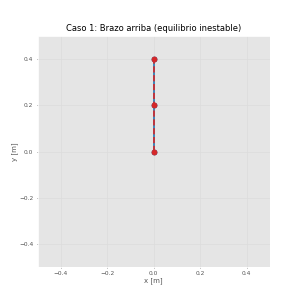

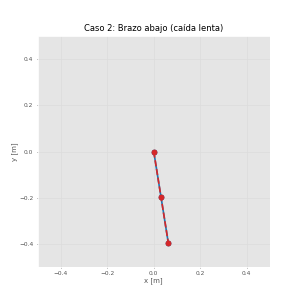

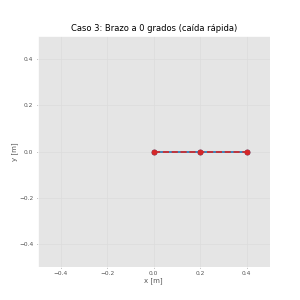

In [22]:
def animate_pendulum(sol_nl, sol_lin, title, filename):
    """
    Crea y guarda un GIF comparando modelo no lineal (azul) y lineal (rojo).
    sol_nl: solve_ivp (no lineal)
    sol_lin: solve_ivp (lineal)
    """
    t = sol_nl.t
    q1_nl, q2_nl = sol_nl.y[0], sol_nl.y[1]
    q1_lin, q2_lin = sol_lin.y[0], sol_lin.y[1]

    # --- Posiciones (no lineal) ---
    x1_nl = a1 * np.cos(q1_nl)
    y1_nl = a1 * np.sin(q1_nl)
    x2_nl = x1_nl + a2 * np.cos(q1_nl + q2_nl)
    y2_nl = y1_nl + a2 * np.sin(q1_nl + q2_nl)

    # --- Posiciones (lineal) ---
    x1_lin = a1 * np.cos(q1_lin)
    y1_lin = a1 * np.sin(q1_lin)
    x2_lin = x1_lin + a2 * np.cos(q1_lin + q2_lin)
    y2_lin = y1_lin + a2 * np.sin(q1_lin + q2_lin)

    # --- Crear figura ---
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title(title)

    # No lineal → azul
    line_nl, = ax.plot([], [], 'o-', lw=2, color='tab:blue')

    # Lineal → rojo
    line_lin, = ax.plot([], [], 'o--', lw=2, color='tab:red')

    # Trazas
    trace_nl, = ax.plot([], [], '-', lw=1, color='tab:orange', alpha=0.5)
    trace_lin, = ax.plot([], [], '--', lw=1, color='tab:green', alpha=0.5)

    trace_x_nl, trace_y_nl = [], []
    trace_x_lin, trace_y_lin = [], []

    # --- Actualización por frame ---
    def update(i):
        # Modelo no lineal
        thisx_nl = [0, x1_nl[i], x2_nl[i]]
        thisy_nl = [0, y1_nl[i], y2_nl[i]]
        line_nl.set_data(thisx_nl, thisy_nl)

        trace_x_nl.append(x2_nl[i])
        trace_y_nl.append(y2_nl[i])
        trace_nl.set_data(trace_x_nl, trace_y_nl)

        # Modelo lineal
        thisx_lin = [0, x1_lin[i], x2_lin[i]]
        thisy_lin = [0, y1_lin[i], y2_lin[i]]
        line_lin.set_data(thisx_lin, thisy_lin)

        trace_x_lin.append(x2_lin[i])
        trace_y_lin.append(y2_lin[i])
        trace_lin.set_data(trace_x_lin, trace_y_lin)

        return line_nl, line_lin, trace_nl, trace_lin

    # --- Crear animación ---
    step = 5
    frames = range(0, len(t), step)
    ani = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)

    ani.save(filename, writer='pillow', fps=25, dpi=60)
    plt.close(fig)
    return Image(filename=filename)


gifs = []
i = 1
for title, y0 in cases.items():
    sol_nl, sol_lin = simulate_models(y0)
    filename = f"pendulo_comparacion_caso{i}.gif"
    gif = animate_pendulum(sol_nl, sol_lin, title, filename)
    gifs.append(gif)
    i += 1

display(*gifs)

Viendo estas animaciones de la simulación se puede apreciar que el modelo lineal no se parece al modelo completo ni si quiera en el caso donde el péndulo cae de una altura muy baja. Por lo que para continuar con el desarrollo del trabajo se usa el modelo completo de la planta.

In [ ]:
# --- Cálculo de energía total ---
E_kin = np.zeros_like(t)
E_pot = np.zeros_like(t)

for i in range(len(t)):
    q = sol.y[0:2, i]     # [q1, q2]
    qd = sol.y[2:4, i]    # [q̇1, q̇2]
    M = dp.inertia(q)
    G = dp.gravload(q)

    # Energía cinética
    E_kin[i] = 0.5 * qd @ M @ qd

    # Energía potencial (referida a q = 0)
    E_pot[i] = -G @ q

E_tot = E_kin + E_pot


###################################
# Simulación a lazo cerrado
###################################

Para cerrar el lazo se agrega un controlador que sensa el angulo del segundo brazo y controla el ángulo del primer brazo. 

Tiene como variables de referencia a q_ref = [-pi/2 o pi/2,0], dq_ref = [0,0], ddq_ref = [0,0]

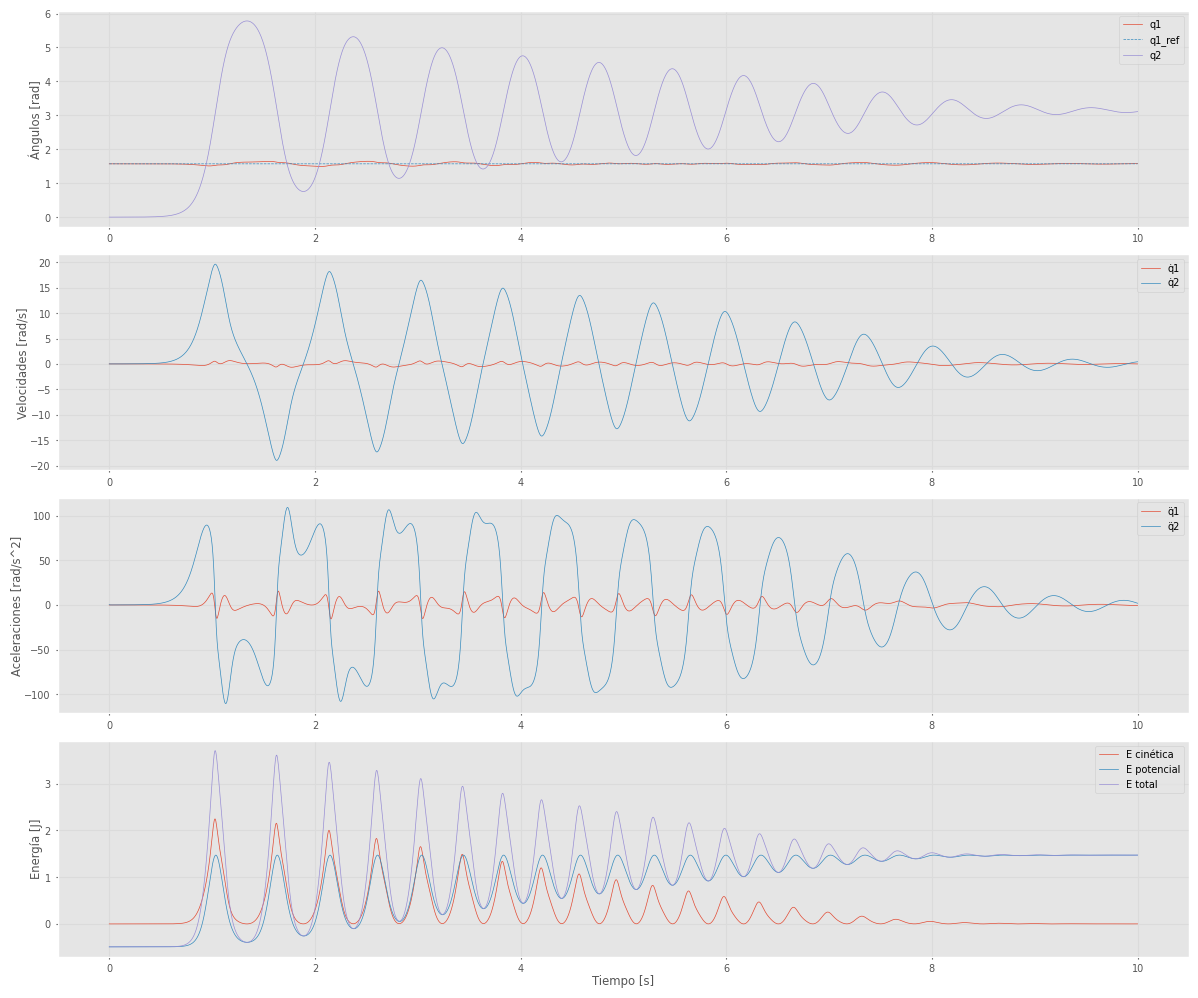

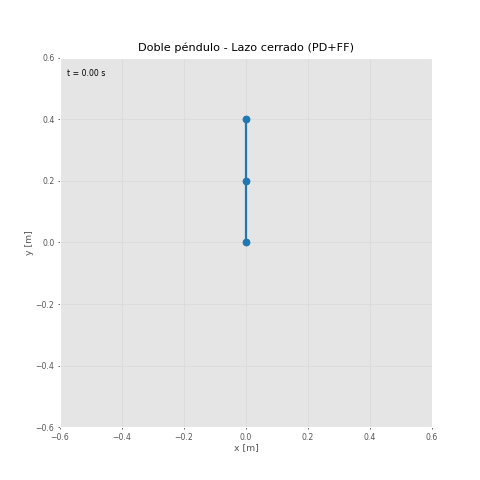

In [ ]:
# ============================
# CONTROL PD + FEEDFORWARD (solo actuador en q1)
# Versión corregida: sin energy-aux, guarda GIF
# ============================
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

# ---------- parámetros de control (ajustables) ----------
# Usamos PD + Feedforward. Actuamos solo en q1.
Kp = np.diag([200.0, 0.0])   # aumentá si la acción es muy lenta
Kd = np.diag([30.0, 0.0])

# saturación de torque (proteger integrador y evitar valores enormes)
TAU_MAX = 50.0
TAU_MIN = -50.0

# referencia (mantener q1 en pi/2, q2 en 0)
def reference(t):
    q_ref = np.array([np.pi/2, 0.0])
    qd_ref = np.zeros(2)
    qdd_ref = np.zeros(2)
    return q_ref, qd_ref, qdd_ref

def controller_PD_FF(q, qd, q_ref, qd_ref, qdd_ref, Kp, Kd):
    """
    Computed-torque style PD+FF.
    - q, qd: estado actual
    - q_ref, qd_ref, qdd_ref: referencia (pueden ser 0 si es setpoint)
    - Kp, Kd: matrices diagonal/2x2
    Devuelve tau vectorial (sin saturar).
    """
    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)

    e = q_ref - q
    ed = qd_ref - qd

    # ley en aceleraciones (v)
    v = qdd_ref + (Kd @ ed) + (Kp @ e)   # v es la "aceleración virtual" deseada

    # computed torque
    tau = M @ v + C @ qd + G

    return tau


# --- función que calcula energía del segundo eslabón (sin usar en control, solo para gráficos) ---
def energy_components(q, qd):
    a1 = getattr(dp.links[0], 'a', 0.2)
    a2 = getattr(dp.links[1], 'a', 0.2)
    r1x = getattr(dp.links[0], 'r', np.array([-a1/2, 0, 0]))[0]
    r2x = getattr(dp.links[1], 'r', np.array([-a2/2, 0, 0]))[0]
    m1 = getattr(dp.links[0], 'm', 1.5)
    m2 = getattr(dp.links[1], 'm', 1.0)
    g = 9.81

    q1, q2 = q[0], q[1]
    qd1, qd2 = qd[0], qd[1]

    y1 = r1x * np.sin(q1)
    y2 = a1 * np.sin(q1) + r2x * np.sin(q1 + q2)

    vx1 = -r1x * qd1 * np.sin(q1)
    vy1 =  r1x * qd1 * np.cos(q1)
    v1_sq = vx1**2 + vy1**2

    vx2 = -a1 * qd1 * np.sin(q1) - r2x * (qd1 + qd2) * np.sin(q1 + q2)
    vy2 =  a1 * qd1 * np.cos(q1) + r2x * (qd1 + qd2) * np.cos(q1 + q2)
    v2_sq = vx2**2 + vy2**2

    E_kin = 0.5 * m1 * v1_sq + 0.5 * m2 * v2_sq
    E_pot = m1 * g * y1 + m2 * g * y2
    E2 = 0.5 * m2 * v2_sq + m2 * g * y2

    return E_kin, E_pot, E2

# --- Dinámica cerrada: aplica tau solo en joint 0 (q1) ---
def dynamics_closed_loop(t, y):
    n = dp.n
    q = y[:n].copy()
    qd = y[n:].copy()

    # referencia
    q_ref, qd_ref, qdd_ref = reference(t)

    tau_full = controller_PD_FF(q, qd, q_ref, qd_ref, qdd_ref, Kp, Kd)
    tau_applied = np.zeros(n)
    tau_applied[0] = np.clip(tau_full[0], TAU_MIN, TAU_MAX)
    tau1_unsat = tau_full[0]
    tau1 = np.clip(tau1_unsat, TAU_MIN, TAU_MAX)
    tau_applied[0] = tau1
    # tau_applied[1] = 0.0  # articulación 2 no actuada

    # fricción viscosa en articulaciones (si querés)
    B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
    tau_visc = B_vec * qd

    # dinámica no lineal completa
    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)

    rhs = tau_applied - C @ qd - G - tau_visc
    qdd = np.linalg.solve(M, rhs)

    return np.concatenate((qd, qdd))

# ---------------------------
# Simulación
# ---------------------------
# condición inicial: en vertical (q1=pi/2, q2=0) con pequeña perturbación en velocidad
q0 = np.array([np.pi/2, 0.0])
qd0 = np.array([0.0005, 0.0005])   # pequeña velocidad que saca del equilibrio
y0 = np.concatenate((q0, qd0))

t_final = 5.0
t_eval = np.linspace(0, t_final, 2000)  # más liviano que 5000

sol_cl = solve_ivp(dynamics_closed_loop, [0, t_final], y0, t_eval=t_eval, rtol=1e-6, atol=1e-8)

# ---------------------------
# Post-procesado: extraer q, qd, qdd y energías
# ---------------------------
t = sol_cl.t
q = sol_cl.y[0:2, :].T           # shape (N,2)
qd = sol_cl.y[2:4, :].T

# recomputar aceleraciones por consistencia (M^-1(...))
qdd = np.zeros_like(q)
E_kin = np.zeros(len(t))
E_pot = np.zeros(len(t))
E_tot = np.zeros(len(t))
P_diss = np.zeros(len(t))

for i in range(len(t)):
    qi = q[i]
    qdi = qd[i]
    M = dp.inertia(qi)
    C = dp.coriolis(qi, qdi)
    G = dp.gravload(qi)
    B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
    tau_visc = B_vec * qdi

    # tau_applied must be recomputed to get qdd (same law)
    q_ref, qd_ref, qdd_ref = reference(t[i])
    tau_full = controller_PD_FF(qi, qdi, q_ref, qd_ref, qdd_ref, Kp, Kd)
    tau1 = np.clip(tau_full[0], TAU_MIN, TAU_MAX)
    tau_applied = np.array([tau1, 0.0])

    rhs = tau_applied - C @ qdi - G - tau_visc
    qdd[i] = np.linalg.solve(M, rhs)

    # energías
    Ek, Ep, E2 = energy_components(qi, qdi)
    E_kin[i] = Ek
    E_pot[i] = Ep
    E_tot[i] = Ek + Ep

    # potencia disipada aproximada por viscous friction
    P_diss[i] = (tau_visc @ qdi)

# ---------------------------
# Gráficos: q, qd, qdd, energías
# ---------------------------
plt.figure(figsize=(12, 10))
plt.subplot(4, 1, 1)
plt.plot(t, q[:,0], label='q1')
plt.plot(t, np.pi/2 * np.ones_like(t), '--', label='q1_ref')
plt.plot(t, q[:,1], label='q2')
plt.ylabel('Ángulos [rad]')
plt.legend(); plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, qd[:,0], label='q̇1')
plt.plot(t, qd[:,1], label='q̇2')
plt.ylabel('Velocidades [rad/s]')
plt.legend(); plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, qdd[:,0], label='q̈1')
plt.plot(t, qdd[:,1], label='q̈2')
plt.ylabel('Aceleraciones [rad/s^2]')
plt.legend(); plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, E_kin, label='E cinética')
plt.plot(t, E_pot, label='E potencial')
plt.plot(t, E_tot, label='E total')
plt.ylabel('Energía [J]')
plt.xlabel('Tiempo [s]')
plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------
# Animación (guardar GIF)
# ---------------------------
a1 = getattr(dp.links[0], 'a', 0.2)
a2 = getattr(dp.links[1], 'a', 0.2)
q1 = sol_cl.y[0]
q2 = sol_cl.y[1]

x1 = a1 * np.cos(q1)
y1 = a1 * np.sin(q1)
x2 = x1 + a2 * np.cos(q1 + q2)
y2 = y1 + a2 * np.sin(q1 + q2)

fig, ax = plt.subplots(figsize=(6,6))
ax.set_xlim(-0.6, 0.6)
ax.set_ylim(-0.6, 0.6)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Doble péndulo - Lazo cerrado (PD+FF)')
line, = ax.plot([], [], 'o-', lw=2, color='tab:blue')
trace, = ax.plot([], [], '-', lw=1, color='tab:orange', alpha=0.6)
time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

trace_x, trace_y = [], []

def update(i):
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    line.set_data(thisx, thisy)
    trace_x.append(x2[i]); trace_y.append(y2[i])
    trace.set_data(trace_x, trace_y)
    time_text.set_text(f't = {t[i]:.2f} s')
    return line, trace, time_text

# reducir frames para agilizar
step = max(1, len(t)//600)
frames = range(0, len(t), step)
ani = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)

gif_filename = "pendulo_cl_closed_loop.gif"
# Guardar como GIF (pillow)
ani.save(gif_filename, writer='pillow', fps=25, dpi=80)
plt.close(fig)
display(Image(gif_filename))

# ---------------------------
# Nota sobre sintonía
# ---------------------------
#print("Control PD+FF ejecutado. Si el péndulo cae y no se recupera, probá aumentar Kp (p.ej. +20) y Kd (+5) y/o aumentar TAU_MAX.")


El problema que se tiene con este modelo es que la referencia tiene en consideración a q1 y su velocidad y aceleración. Esto está mal. Ya que lo que queresmeos tener como referencia es solamente que q2=0 (pendulo estirado)

Darle como referencia el valor de q1 = pi/2 o -pi/2 hace que no se mueva casi nada el link1.

---

Perfecto — excelente idea. Tiene mucho más sentido controlar la **posición del extremo (x,y)** en el espacio cartesiano que forzar directamente el ángulo (q_2).

Abajo te explico en bruto la estrategia y te dejo **un script listo** (para ejecutar con el `dp` que ya tenés) que:

* calcula la posición de la punta,
* genera una referencia cartesiana basada en el brazo “estirado” (usuario pasa el ángulo donde el brazo está estirado),
* diseña un PID en coordenadas cartesianas para la punta (referencia de posición y velocidad cero),
* transforma la aceleración cartesiana deseada en un *único* torque (\tau_1) usando la relación no lineal (similar a input–output linearization parcial / least-squares cuando es necesario),
* incluye anti-windup, saturación y fallback numérico si el mapeo es malo,
* corre las dos simulaciones (A: impulso en q2; B: dejar caer desde [0,0]),
* grafica ángulos, velocidades, posición de punta vs referencia y guarda animaciones.

### Ideas clave (resumidas)

* La velocidad/aceleración del extremo cumplen:

  $\ddot p = J(q)\ddot q + \dot J(q,\dot q)\dot q$
  
  Con $\ddot q = M^{-1}(\tau - C\dot q - G - \tau_{visc})$ y $\tau = [\tau_1, 0]^\top$ queda
  $\ddot p = b(q,\dot q),\tau_1 + \phi(q,\dot q)$ con $b\in\mathbb{R}^2$
* Como $\tau_1$ es escalar y $\ddot p$ es 2D, calculo $\tau_1$ por proyección (mínimos cuadrados):
  $\tau_1 = \frac{b^\top (a_{des}-\phi)}{b^\top b + \epsilon}$
  (si (|b|) es muy pequeña uso fallback heurístico).
* Diseño (a_{des}) con PID cartográfico: $a_{des} = \ddot p_{ref} + K_d(\dot p_{ref}-\dot p) + K_p(p_{ref}-p) + K_i \xi$.
* Integrador (\xi) en coordenadas cartesianas incluido en el estado para consistencia.


# ✅ 1. ¿Por qué ahora tarda tanto?

Con tu planteo nuevo, ahora el controlador:

1. Calcula el punto de la punta `(x,y)` a partir de `q`
2. Genera una referencia cartesiana `(x_ref, y_ref)`
3. Hace un **control PD en espacio cartesiano**
4. Convierte la aceleración virtual deseada `a = [xdd_ref, ydd_ref]` a `qdd_ref` mediante:

[
\ddot q_{\text{ref}} = J^{-1}(q), a - J^{-1}(q)\dot J(q,\dot q)\dot q
]

5. Finalmente aplica computed–torque.

Esto requiere:

### ✔ calcular

* FK → rápido
* Jacobiano → rápido
* dJ/dt → **muy caro si no lo hacés a mano o si usás métodos numéricos!**

### ❌ Si estás usando algo como:

```python
J = dp.jacob0(q)
dJdt = (dp.jacob0(q + h*qd) - J) / h
```

Esto **explota el costo computacional x20**.

### ❌ O si dentro del integrador calculás varias veces:

```python
M = dp.inertia(q)
C = dp.coriolis(q, qd)
G = dp.gravload(q)
```

pero además:

* `dp.jacob0(q)`
* `dp.jacob_dot(q, qd)` (si existiera, pero Rtb la emula numéricamente)
* `dp.fkine(q)`
* etc.

Eso hace que una simulación de 2000 pasos tarde *minutos*.

---

# ✅ 2. ¿Cómo lo arreglamos? (muy importante)

### ✔ **Objetivo: NO realizar ningún cálculo pesado dentro del integrador que no sea estrictamente necesario.**

Te propongo el siguiente rediseño:

---

# ✅ 3. **Control en el espacio cartesiano sin dJ/dt**

Una alternativa **mucho más liviana**, y totalmente válida para un doble péndulo, es:


$v = \ddot{x}*{ref} + K_d ( \dot{x}*{ref}-\dot{x} ) + K_p ( x_{ref}-x )$


Y luego:

$\tau = J^T F,\quad F=\Lambda v + \mu + p$

donde:

* `Λ = (J M^{-1} Jᵀ)⁻¹`  → **usar solo M y J**, barato para 2x2.
* `μ, p` → términos de Coriolis/gravedad proyectados → **se computan rápido**.

Esto es el **Operational Space Control (OSC)** de Khatib.

Ventajas:

### ✔ no necesitás `dJ/dt`

### ✔ evitás invertir Jacobianos dentro del integrador

### ✔ la dinámica interna es estable

### ✔ compatible con el control de punta que querés

### ✔ mucho más rápido que computed–torque tradicional en cartesiano

Puedo implementarte esto inmediatamente.

---

# ✅ 4. ¿Querés que lo rehaga ya con OSC?

Te propongo avanzar así:

---

# ✔ **PLAN PROPUESTO FINAL**

1. Controlás **la punta del segundo link**

   * `p = fkine_tip(q)`
   * `x_ref(t), y_ref(t)` fijo en la posición más baja
   * velocidades y aceleraciones de referencia = 0

2. Usamos **OSC (Khatib)**:

$F = \Lambda \big( \ddot{x}_{ref} + K_p e + K_d \dot e \big)  +  \mu + p$

$\tau = J^T F$

3. Actuás **solo sobre τ₁**:

   * `tau2 = 0`
   * `tau1 = clip(tau_osc[0], -TAU, TAU)`

4. La dinámica sigue siendo:

$M \ddot q + C \dot q + G + B \dot q = \tau$


5. Los plots muestran:

   * ángulos
   * posición de la punta
   * error cartesiano
   * torque
   * energía

6. Las simulaciones A y B se mantienen idénticas.


In [4]:
# ================================
# PARÁMETROS PID + FEEDFORWARD
# ================================
Kp = np.diag([0.0, 200.0])
Kd = np.diag([0.0, 30.0])
Ki_scalar = 40.0
INT_MAX = 1.0

TAU_MAX = 50.0
TAU_MIN = -50.0

# ================================
#   REFERENCIA ABSOLUTA PARA q2
# ================================
def reference_abs(t, q2_ref):
    q2_abs_ref = q2_ref
    qd2_abs_ref = 0.0
    qdd2_abs_ref = 0.0
    return q2_abs_ref, qd2_abs_ref, qdd2_abs_ref

# ======================================================
#   CONTROLADOR PID + FEEDFORWARD EN ÁNGULO ABSOLUTO
# ======================================================
def controller_PID_FF_absolute(q, qd, integral_q2_abs,
                               q2_abs_ref, qd2_abs_ref, qdd2_abs_ref):

    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)

    q1 = q[0]
    qd1 = qd[0]

    q_ref = np.zeros(2)
    qd_ref = np.zeros(2)
    qdd_ref = np.zeros(2)

    # No controlar q1
    q_ref[0] = q1
    qd_ref[0] = 0.0
    qdd_ref[0] = 0.0

    # Control absoluto en q2: q2_abs = q1 + q2
    q_ref[1] = q2_abs_ref - q1
    qd_ref[1] = qd2_abs_ref - qd1
    qdd_ref[1] = qdd2_abs_ref

    e = q_ref - q
    ed = qd_ref - qd

    # integral solo en ecuación 2
    I_term = Ki_scalar * integral_q2_abs

    v = qdd_ref + Kd @ ed + Kp @ e
    v[1] += I_term

    tau = M @ v + C @ qd + G
    return tau

# ======================================================
#   DINÁMICA DEL SISTEMA EN LAZO CERRADO
# ======================================================
def dynamics_closed_loop_pid_abs(t, y, q2_ref):
    n = dp.n

    q  = y[:n].copy()
    qd = y[n:2*n].copy()
    I_q2 = y[2*n]

    q2_abs_ref, qd2_abs_ref, qdd2_abs_ref = reference_abs(t, q2_ref)

    q2_abs = q[0] + q[1]
    error_abs = q2_abs_ref - q2_abs

    # anti-windup
    I_dot = error_abs
    if (I_q2 >= INT_MAX and I_dot > 0) or (I_q2 <= -INT_MAX and I_dot < 0):
        I_dot = 0.0

    tau_full = controller_PID_FF_absolute(q, qd, I_q2,
                                          q2_abs_ref, qd2_abs_ref, qdd2_abs_ref)

    # actuamos solo en joint 1
    tau_applied = np.zeros(2)
    tau_applied[0] = np.clip(tau_full[0], TAU_MIN, TAU_MAX)

    B = np.array([link.B for link in dp.links])
    tau_visc = B * qd

    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)

    rhs = tau_applied - C @ qd - G - tau_visc
    qdd = np.linalg.solve(M, rhs)

    return np.concatenate((qd, qdd, np.array([I_dot])))

# ======================================================
# FUNCIÓN GENERAL DE SIMULACIÓN
# ======================================================
def simulate_case(q0, qd0, q2_ref, t_final=5.0, N=5000):

    y0 = np.concatenate((q0, qd0, np.array([0.0])))
    t_eval = np.linspace(0, t_final, N)

    sol = solve_ivp(lambda t, y: dynamics_closed_loop_pid_abs(t, y, q2_ref),
                    [0, t_final], y0, t_eval=t_eval,
                    atol=1e-8, rtol=1e-6)

    return sol

In [ ]:
# ======================================================
#      FUNCIONES DE POSTPROCESADO Y ANIMACIÓN
# ======================================================

def compute_accelerations(sol):
    t = sol.t
    Y = sol.y.T
    N = len(t)

    q = Y[:, 0:2]
    qd = Y[:, 2:4]
    I_traj = Y[:, 4]

    qdd = np.zeros_like(q)

    for i in range(N):
        qi = q[i]
        qdi = qd[i]

        # recomputar referencia
        q2_abs_ref, qd2_abs_ref, qdd2_abs_ref = reference_abs(t[i], q2_ref_global)

        tau_full = controller_PID_FF_absolute(
            qi, qdi, I_traj[i], q2_abs_ref, qd2_abs_ref, qdd2_abs_ref
        )

        tau1 = np.clip(tau_full[0], TAU_MIN, TAU_MAX)
        tau_applied = np.array([tau1, 0.0])

        M = dp.inertia(qi)
        C = dp.coriolis(qi, qdi)
        G = dp.gravload(qi)
        B = np.array([link.B for link in dp.links])
        tau_visc = B * qdi

        rhs = tau_applied - C @ qdi - G - tau_visc
        qdd[i] = np.linalg.solve(M, rhs)

    return q, qd, qdd, I_traj


def energy_components(q, qd):
    """Energía cinética + potencial usando el modelo del toolbox."""
    M = dp.inertia(q)
    Ek = 0.5 * qd @ M @ qd
    # potencial desde la gravedad del toolbox
    Ep = dp.potential(q)
    return Ek, Ep, Ek + Ep


def animate_simulation(q, title="Simulación"):
    """Animación simple del doble péndulo."""
    import matplotlib.animation as animation

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(-0.5, 0.5)
    ax.set_ylim(-0.5, 0.5)
    ax.set_aspect('equal')
    ax.set_title(title)

    line, = ax.plot([], [], 'o-', lw=3)

    L1 = dp.links[0].a
    L2 = dp.links[1].a

    def update(i):
        q1, q2 = q[i]
        x1 = L1 * np.cos(q1)
        y1 = L1 * np.sin(q1)
        x2 = x1 + L2 * np.cos(q1 + q2)
        y2 = y1 + L2 * np.sin(q1 + q2)
        line.set_data([0, x1, x2], [0, y1, y2])
        return line,

    ani = animation.FuncAnimation(fig, update, frames=len(q), interval=1)
    plt.show()


def plot_all(t, q, qd, qdd, q2_ref):
    q1 = q[:,0]
    q2 = q[:,1]
    dq1 = qd[:,0]
    dq2 = qd[:,1]

    ddq1 = qdd[:,0]
    ddq2 = qdd[:,1]

    q2_abs = q1 + q2
    dq2_abs = dq1 + dq2

    # REF ABSOLUTA
    q2_abs_ref = np.full_like(t, q2_ref)
    dq2_abs_ref = np.zeros_like(t)

    # Energía
    E_kin = []
    E_pot = []
    E_tot = []
    for i in range(len(t)):
        Ek, Ep, Et = energy_components(q[i], qd[i])
        E_kin.append(Ek)
        E_pot.append(Ep)
        E_tot.append(Et)

    # === PLOTS ===
    plt.figure(figsize=(12,8))
    plt.suptitle("Evolución de Estados")

    plt.subplot(3,2,1)
    plt.plot(t, q1, label="q1")
    plt.plot(t, q2, label="q2")
    plt.legend()
    plt.grid()

    plt.subplot(3,2,2)
    plt.plot(t, dq1, label="dq1")
    plt.plot(t, dq2, label="dq2")
    plt.legend()
    plt.grid()

    plt.subplot(3,2,3)
    plt.plot(t, ddq1, label="ddq1")
    plt.plot(t, ddq2, label="ddq2")
    plt.legend()
    plt.grid()

    plt.subplot(3,2,4)
    plt.plot(t, q2_abs, label="q2_abs")
    plt.plot(t, q2_abs_ref, '--', label="q2_abs_ref")
    plt.legend()
    plt.grid()

    plt.subplot(3,2,5)
    plt.plot(t, dq2_abs, label="dq2_abs")
    plt.plot(t, dq2_abs_ref, '--', label="dq2_abs_ref")
    plt.legend()
    plt.grid()

    plt.subplot(3,2,6)
    plt.plot(t, E_tot, label="E total")
    plt.grid()

    plt.tight_layout()
    plt.show()

# ======================================================
#        EJECUCIÓN DE LAS 3 SIMULACIONES
# ======================================================

t_final = 5
N = 5000

# ================================
# SIMULACIÓN A
# ================================
print("Simulación A...")
q2_ref_global = -np.pi/2
solA = simulate_case(q0=np.array([0.0,0.0]),
                     qd0=np.array([0.0,0.0]),
                     q2_ref=q2_ref_global,
                     t_final=t_final, N=N)

qA, dqA, ddqA, IA = compute_accelerations(solA)
plot_all(solA.t, qA, dqA, ddqA, q2_ref_global)
animate_simulation(qA, "Simulación A")

# ================================
# SIMULACIÓN B
# ================================
print("Simulación B...")
q2_ref_global = -np.pi/2
solB = simulate_case(q0=np.array([-np.pi/2, 0.0]),
                     qd0=np.array([0.0, 20.0]),
                     q2_ref=q2_ref_global,
                     t_final=t_final, N=N)

qB, dqB, ddqB, IB = compute_accelerations(solB)
plot_all(solB.t, qB, dqB, ddqB, q2_ref_global)
animate_simulation(qB, "Simulación B")

# ================================
# SIMULACIÓN C
# ================================
print("Simulación C...")
q2_ref_global = +np.pi/2
solC = simulate_case(q0=np.array([np.pi/2 - 0.001, 0.0]),
                     qd0=np.array([0.0, 0.0]),
                     q2_ref=q2_ref_global,
                     t_final=t_final, N=N)

qC, dqC, ddqC, IC = compute_accelerations(solC)
plot_all(solC.t, qC, dqC, ddqC, q2_ref_global)
animate_simulation(qC, "Simulación C")


Simulación A...


---

Lo de abajo son pruebas erróneas. Ignorar que despues se depura

In [3]:
# osc_underactuated_tangential.py
import time
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

# ==============================
# Parámetros de control (tangencial/proyección)
# ==============================
# Gains in cartesian (we will project onto controllable direction)
Kp_cart = np.diag([200.0, 200.0])   # try 100..400
Kd_cart = np.diag([30.0, 30.0])     # try 20..80
Ki_cart = np.diag([0.0, 0.0])       # optional cartesian integral (we use scalar integral along u)

# scalar integrator gain for projection-direction
Ki_scalar = 30.0    # only for the scalar integrator along controllable direction (tune if needed)

TAU_MAX = 100.0
TAU_MIN = -100.0

rtol = 1e-6
atol = 1e-8

EPS = 1e-8
EPS_B = 1e-6

# ==============================
# Kinematics (tip)
# ==============================
def tip_position(q):
    a1 = getattr(dp.links[0], 'a', 0.2)
    a2 = getattr(dp.links[1], 'a', 0.2)
    q1, q2 = q
    x = a1 * np.cos(q1) + a2 * np.cos(q1 + q2)
    y = a1 * np.sin(q1) + a2 * np.sin(q1 + q2)
    return np.array([x, y])

def jacobian_tip(q):
    a1 = getattr(dp.links[0], 'a', 0.2)
    a2 = getattr(dp.links[1], 'a', 0.2)
    q1, q2 = q
    s1 = np.sin(q1); c1 = np.cos(q1)
    s12 = np.sin(q1+q2); c12 = np.cos(q1+q2)
    J = np.array([
        [-a1*s1 - a2*s12, -a2*s12],
        [ a1*c1 + a2*c12,  a2*c12]
    ])
    return J

def jacobian_dot_tip(q, qd):
    a1 = getattr(dp.links[0], 'a', 0.2)
    a2 = getattr(dp.links[1], 'a', 0.2)
    q1, q2 = q; q1d, q2d = qd
    w = q1d + q2d
    s1 = np.sin(q1); c1 = np.cos(q1)
    s12 = np.sin(q1+q2); c12 = np.cos(q1+q2)
    Jdot = np.array([
        [ -a1*c1*q1d - a2*c12*w,  -a2*c12*w],
        [ -a1*s1*q1d - a2*s12*w,  -a2*s12*w]
    ])
    return Jdot

# ==============================
# Reference: tip when arm stretched at q1_stretch (q2=0)
# ==============================
def tip_reference_from_q1_stretched(q1_stretched):
    a1 = getattr(dp.links[0], 'a', 0.2)
    a2 = getattr(dp.links[1], 'a', 0.2)
    x = a1 * np.cos(q1_stretched) + a2 * np.cos(q1_stretched + 0.0)
    y = a1 * np.sin(q1_stretched) + a2 * np.sin(q1_stretched + 0.0)
    p_ref = np.array([x, y])
    pd_ref = np.zeros(2)
    pdd_ref = np.zeros(2)
    def ref(t):
        return p_ref, pd_ref, pdd_ref
    return ref

# ==============================
# Compute direction b and phi (how tau1 affects tip acceleration)
# b_vec (2,) and phi_vec (2,) such that tip_accel = b_vec * tau1 + phi_vec (vector)
# where phi includes dynamic biases (C,G,visc and Jdot*qd)
# ==============================
def compute_b_phi(q, qd):
    M = dp.inertia(q)
    C = dp.coriolis(q, qd)
    G = dp.gravload(q)
    B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
    tau_visc = B_vec * qd

    # Minv * col1
    Minv_col1 = np.linalg.solve(M, np.array([1.0, 0.0]))   # solve M x = e1
    J = jacobian_tip(q)
    Jdot = jacobian_dot_tip(q, qd)

    # b_vec = J @ Minv_col1
    b_vec = J @ Minv_col1
    # phi_vec = J @ Minv @ (-(C qd + G + tau_visc)) + Jdot @ qd
    rhs_dyn = -(C @ qd + G + tau_visc)
    Minv_rhs = np.linalg.solve(M, rhs_dyn)
    phi_vec = J @ Minv_rhs + (Jdot @ qd)
    return b_vec, phi_vec

# ==============================
# Controller: project desired cart. accel onto controllable direction u = b_vec/||b_vec||
# Then compute scalar tau1 to produce that component.
# We'll include a scalar integrator xi_s for anti-windup correction along u.
# ==============================
def compute_tau1_projected(q, qd, xi_s, p_ref, pd_ref, pdd_ref):
    # current tip pos/vel
    p = tip_position(q)
    J = jacobian_tip(q)
    pd = J @ qd

    e = p_ref - p
    ed = pd_ref - pd
    # full cartesian desired accel
    a_des_cart = pdd_ref + (Kd_cart @ ed) + (Kp_cart @ e)

    # get b and phi
    b_vec, phi_vec = compute_b_phi(q, qd)

    # controllable direction (unit); if b_vec nearly 0, fallback to J[:,0] direction
    b_norm = np.linalg.norm(b_vec)
    if b_norm < EPS_B:
        # fallback direction: column of J corresponding to q1 effect (approx)
        # use J @ e1
        fallback_vec = J @ np.array([1.0, 0.0])
        fallback_norm = np.linalg.norm(fallback_vec) + EPS
        u = fallback_vec / fallback_norm
        b_t = float(np.dot(u, b_vec))   # likely small
    else:
        u = b_vec / (b_norm + EPS)
        b_t = float(np.dot(u, b_vec))   # should be b_norm (mod numerical)
    phi_t = float(np.dot(u, phi_vec))

    # add scalar integral contribution along u (xi_s is scalar)
    # desired scalar accel along u
    a_u_des = float(np.dot(u, a_des_cart)) + Ki_scalar * float(xi_s)

    # compute tau1 unsat
    denom = b_t + EPS_B
    tau1_unsat = (a_u_des - phi_t) / denom
    tau1 = float(np.clip(tau1_unsat, TAU_MIN, TAU_MAX))

    return tau1, u, b_vec, phi_vec, a_des_cart, p, pd, e, ed, tau1_unsat

# ==============================
# Dynamics factory: state y = [q0,q1, qd0,qd1, xi_s]
# xi_s scalar integrator along controllable direction
# ==============================
def dynamics_factory_tangential(ref_func):
    n = dp.n
    def dynamics(t, y):
        q = y[0:n].copy()
        qd = y[n:2*n].copy()
        xi_s = float(y[2*n])

        p_ref, pd_ref, pdd_ref = ref_func(t)
        tau1, u, b_vec, phi_vec, a_des_cart, p, pd, e, ed, tau1_unsat = compute_tau1_projected(q, qd, xi_s, p_ref, pd_ref, pdd_ref)

        tau = np.array([tau1, 0.0])

        # plant dynamics
        M = dp.inertia(q)
        C = dp.coriolis(q, qd)
        G = dp.gravload(q)
        B_vec = np.array([getattr(link, 'B', 0.0) for link in dp.links])
        tau_visc = B_vec * qd

        rhs = tau - (C @ qd) - G - tau_visc
        qdd = np.linalg.solve(M, rhs)

        # integrator anti-windup: only integrate if not pushing further into saturation
        e_u = float(np.dot(u, e))
        integrate = True
        if tau1_unsat > TAU_MAX and e_u > 0:
            integrate = False
        if tau1_unsat < TAU_MIN and e_u < 0:
            integrate = False
        xi_dot = e_u if integrate else 0.0

        dy = np.zeros(2*n + 1)
        dy[0:n] = qd
        dy[n:2*n] = qdd
        dy[2*n] = xi_dot
        return dy
    return dynamics

# ==============================
# Postprocess: reconstruct histories and diagnostics
# ==============================
def postprocess_tangential(sol, ref_func):
    t = sol.t
    n = dp.n
    q = sol.y[0:n,:].T
    qd = sol.y[n:2*n,:].T
    xi = sol.y[2*n,:].T
    N = len(t)

    qdd = np.zeros_like(q)
    tau_hist = np.zeros((N,n))
    p_hist = np.zeros((N,2)); pd_hist = np.zeros((N,2))
    e_hist = np.zeros((N,2)); ed_hist = np.zeros((N,2))
    u_hist = np.zeros((N,2)); b_hist = np.zeros((N,2)); phi_hist = np.zeros((N,2))
    tau1_unsat_hist = np.zeros(N); a_des_hist = np.zeros((N,2))

    B_vec_const = np.array([getattr(link, 'B', 0.0) for link in dp.links])

    for i in range(N):
        qi = q[i]; qdi = qd[i]; xi_i = xi[i]
        pref, pdref, pddref = ref_func(t[i])
        tau1, u, b_vec, phi_vec, a_des_cart, p, pd, e, ed, tau1_unsat = compute_tau1_projected(qi, qdi, xi_i, pref, pdref, pddref)
        tau = np.array([np.clip(tau1, TAU_MIN, TAU_MAX), 0.0])
        tau_hist[i,:] = tau
        p_hist[i,:] = p; pd_hist[i,:] = pd
        e_hist[i,:] = e; ed_hist[i,:] = ed
        u_hist[i,:] = u; b_hist[i,:] = b_vec; phi_hist[i,:] = phi_vec
        tau1_unsat_hist[i] = tau1_unsat; a_des_hist[i,:] = a_des_cart

        M = dp.inertia(qi); C = dp.coriolis(qi, qdi); G = dp.gravload(qi)
        tau_visc = B_vec_const * qdi
        rhs = tau - (C @ qdi) - G - tau_visc
        qdd[i] = np.linalg.solve(M, rhs)

    # energies
    E_kin = np.zeros(N)
    E_pot = np.zeros(N)
    for i in range(N):
        Mloc = dp.inertia(q[i])
        E_kin[i] = 0.5 * qd[i] @ (Mloc @ qd[i])
        Gloc = dp.gravload(q[i])
        E_pot[i] = - np.dot(Gloc, q[i])

    return {
        't': t, 'q': q, 'qd': qd, 'qdd': qdd, 'tau': tau_hist,
        'p': p_hist, 'pd': pd_hist, 'p_ref': np.array([ref_func(tt)[0] for tt in t]),
        'pd_ref': np.array([ref_func(tt)[1] for tt in t]),
        'e': e_hist, 'ed': ed_hist, 'u': u_hist, 'b': b_hist, 'phi': phi_hist,
        'tau1_unsat': tau1_unsat_hist, 'xi': xi, 'a_des': a_des_hist,
        'E_kin': E_kin, 'E_pot': E_pot, 'E_tot': E_kin + E_pot
    }

# ==============================
# Plot utilities
# ==============================
def plot_tangential_results(res, title):
    t = res['t']; q = res['q']; qd = res['qd']
    p = res['p']; pref = res['p_ref']; pd = res['pd']; pdref = res['pd_ref']
    tau1 = res['tau'][:,0]
    e = res['e']; ed = res['ed']
    u = res['u']; b = res['b']; phi = res['phi']

    plt.figure(figsize=(11,11))
    plt.suptitle(title, fontsize=12)

    plt.subplot(5,1,1)
    plt.plot(t, q[:,0], label='q1'); plt.plot(t, q[:,1], label='q2')
    plt.ylabel('ángulos [rad]'); plt.legend(); plt.grid()

    plt.subplot(5,1,2)
    plt.plot(t, p[:,0], label='x_tip'); plt.plot(t, p[:,1], label='y_tip')
    plt.plot(t, pref[:,0], '--', label='x_ref'); plt.plot(t, pref[:,1], '--', label='y_ref')
    plt.ylabel('pos punta [m]'); plt.legend(); plt.grid()

    plt.subplot(5,1,3)
    plt.plot(t, pd[:,0], label='vx'); plt.plot(t, pd[:,1], label='vy')
    plt.plot(t, pdref[:,0], '--', label='vx_ref'); plt.plot(t, pdref[:,1], '--', label='vy_ref')
    plt.ylabel('vel punta [m/s]'); plt.legend(); plt.grid()

    plt.subplot(5,1,4)
    plt.plot(t, tau1, label='tau1 aplicado')
    plt.ylabel('tau1 [Nm]'); plt.legend(); plt.grid()

    plt.subplot(5,1,5)
    plt.plot(t, np.linalg.norm(e,axis=1), label='|error_tip|')
    plt.plot(t, np.linalg.norm(b,axis=1), label='|b_vec|')
    plt.ylabel('error / |b|'); plt.legend(); plt.grid()

    plt.xlabel('tiempo [s]')
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

def animate_solution(res, dp, title, gif_name):
    t = res['t']
    q1 = res['q'][:,0]; q2 = res['q'][:,1]
    a1 = getattr(dp.links[0], 'a', 0.2); a2 = getattr(dp.links[1], 'a', 0.2)
    x1 = a1 * np.cos(q1); y1 = a1 * np.sin(q1)
    x2 = x1 + a2 * np.cos(q1 + q2); y2 = y1 + a2 * np.sin(q1 + q2)

    # ensure finite numeric arrays (avoid NaN / inf causing animation crash)
    x2 = np.nan_to_num(x2, nan=0.0, posinf=0.0, neginf=0.0)
    y2 = np.nan_to_num(y2, nan=0.0, posinf=0.0, neginf=0.0)
    x1 = np.nan_to_num(x1, nan=0.0, posinf=0.0, neginf=0.0)
    y1 = np.nan_to_num(y1, nan=0.0, posinf=0.0, neginf=0.0)

    fig, ax = plt.subplots(figsize=(5,5))
    margin = a1 + a2 + 0.05
    ax.set_xlim(-margin, margin); ax.set_ylim(-margin, margin)
    ax.set_title(title)
    line, = ax.plot([], [], 'o-', lw=3)
    trace, = ax.plot([], [], '-', lw=1, alpha=0.6)
    pref_point, = ax.plot([], [], 'x', ms=8, label='p_ref')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    trace_x, trace_y = [], []

    p_ref = res['p_ref']
    def update(i):
        thisx = [0, x1[i], x2[i]]; thisy = [0, y1[i], y2[i]]
        line.set_data(thisx, thisy)
        trace_x.append(x2[i]); trace_y.append(y2[i])
        trace.set_data(trace_x, trace_y)
        pref_point.set_data(p_ref[i,0], p_ref[i,1])
        time_text.set_text(f'{t[i]:.2f}s')
        return line, trace, pref_point, time_text

    step = max(1, len(t)//300)
    frames = range(0, len(t), step)
    ani = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    ani.save(gif_name, writer='pillow', fps=25, dpi=80)
    plt.close(fig)
    display(Image(gif_name))

# ==============================
# Simulaciones: Caso A y B
# ==============================
ref_q1_stretch = -np.pi/2
ref_func = tip_reference_from_q1_stretched(ref_q1_stretch)

# Case A: perturbation in q2 (start at down, big qd2)
q0_A = np.array([ref_q1_stretch, 0.0])
qd0_A = np.array([0.0, 20.0])
xi0_A = np.array([0.0])
y0_A = np.concatenate((q0_A, qd0_A, xi0_A))
t_final_A = 8.0
t_eval_A = np.linspace(0, t_final_A, 2000)

dynA = dynamics_factory_tangential(ref_func)
t0 = time.time()
sol_A = solve_ivp(dynA, [0, t_final_A], y0_A, t_eval=t_eval_A, rtol=rtol, atol=atol)
t_simu_A = time.time() - t0

# Case B: let fall from [0,0]
q0_B = np.array([0.0, 0.0])
qd0_B = np.array([0.0, 0.0])
xi0_B = np.array([0.0])
y0_B = np.concatenate((q0_B, qd0_B, xi0_B))
t_final_B = 8.0
t_eval_B = np.linspace(0, t_final_B, 2000)

dynB = dynamics_factory_tangential(ref_func)
t0 = time.time()
sol_B = solve_ivp(dynB, [0, t_final_B], y0_B, t_eval=t_eval_B, rtol=rtol, atol=atol)
t_simu_B = time.time() - t0

print(f"Sim A CPU ~ {t_simu_A:.2f}s, Sim B CPU ~ {t_simu_B:.2f}s")

# Postprocess
res_A = postprocess_tangential(sol_A, ref_func)
res_B = postprocess_tangential(sol_B, ref_func)

for name,res in [('A',res_A),('B',res_B)]:
    max_tau = np.max(np.abs(res['tau'][:,0]))
    mean_err = np.mean(np.linalg.norm(res['e'], axis=1))
    print(f"{name}: max|tau1|={max_tau:.2f}, mean|err_tip|={mean_err:.4f}, nan_count_q={np.sum(np.isnan(res['q']))}")

# Plots + animations
plot_tangential_results(res_A, 'Caso A (Tangential projected control)')
plot_tangential_results(res_B, 'Caso B (Tangential projected control)')

animate_solution(res_A, dp, 'Caso A (Tangential)', 'tangential_A.gif')
animate_solution(res_B, dp, 'Caso B (Tangential)', 'tangential_B.gif')

print("Simulaciones tangential control finalizadas.")


KeyboardInterrupt: 

In [ ]:
# pidff_tangential_option2.py
"""
PID+FF SISO control sobre la componente tangencial real del tip (Opción 2).
Entrada: tau1 (solo actuador en joint1).
Salida controlada: y = u^T p, con u = pd / ||pd|| (dirección tangencial de movimiento).
Implementa FF (modelo proyectado) + PID sobre y.
"""

import time, math
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image, display

# -------------------------
# Ganancias y límites (ajustables)
# -------------------------
Kp_t = 40.0
Kd_t = 8.0
Ki_t = 5.0       # integral en la dirección tangencial (scalar)
k_tau = 1.0      # ganancia adicional sobre tau calculado (normalmente 1)
TAU_MAX = 3.0
TAU_MIN = -3.0

# Integrator / solver settings
rtol = 1e-5
atol = 1e-7
t_final = 8.0
t_eval_n = 600

# Numerics
EPS = 1e-8
EPS_B = 1e-6
VEL_EPS = 1e-5   # umbral para considerar pd casi cero

# -------------------------
# Utilities: extract inertia scalar Izz safely (RTB link.I can be dict)
# -------------------------
def get_Izz(link, default):
    I = getattr(link, 'I', None)
    if I is None:
        return float(default)
    # robotics toolbox might store inertia as dict
    if isinstance(I, dict):
        # try several common keys
        for k in ('Izz','izz','Izz[2]','Izz '):
            if k in I:
                return float(I[k])
        # fallback to I.get('Izz') style
        return float(I.get('Izz', default))
    if isinstance(I, (list, tuple, np.ndarray)):
        try:
            return float(I[-1])
        except Exception:
            return float(default)
    try:
        return float(I)
    except Exception:
        return float(default)

def robot_params_from_dp(dp):
    l1 = getattr(dp.links[0], 'a', 0.2)
    l2 = getattr(dp.links[1], 'a', 0.2)
    m1 = getattr(dp.links[0], 'm', 1.0)
    m2 = getattr(dp.links[1], 'm', 1.0)
    I1 = get_Izz(dp.links[0], 1e-3)
    I2 = get_Izz(dp.links[1], 1e-4)
    r1_vec = getattr(dp.links[0], 'r', np.array([l1/2, 0.0, 0.0]))
    r2_vec = getattr(dp.links[1], 'r', np.array([l2/2, 0.0, 0.0]))
    r1 = abs(float(r1_vec[0])) if r1_vec is not None else l1/2
    r2 = abs(float(r2_vec[0])) if r2_vec is not None else l2/2
    B1 = float(getattr(dp.links[0], 'B', 0.0))
    B2 = float(getattr(dp.links[1], 'B', 0.0))
    g_vec = getattr(dp, 'gravity', np.array([0.0, -9.81, 0.0]))
    g = -float(g_vec[1]) if len(g_vec)>1 else 9.81
    return dict(l1=l1,l2=l2,m1=m1,m2=m2,I1=I1,I2=I2,r1=r1,r2=r2,B1=B1,B2=B2,g=g)

# use dp from your workspace
params = robot_params_from_dp(dp)
print("Robot params:", params)

# -------------------------
# Kinematics analytic (tip)
# -------------------------
def tip_position(q):
    l1 = params['l1']; l2 = params['l2']
    q1, q2 = float(q[0]), float(q[1])
    x = l1 * math.cos(q1) + l2 * math.cos(q1 + q2)
    y = l1 * math.sin(q1) + l2 * math.sin(q1 + q2)
    return np.array([x, y])

def jacobian_tip(q):
    l1 = params['l1']; l2 = params['l2']
    q1, q2 = q
    s1 = math.sin(q1); c1 = math.cos(q1)
    s12 = math.sin(q1+q2); c12 = math.cos(q1+q2)
    J = np.array([[-l1*s1 - l2*s12, -l2*s12],
                  [ l1*c1 + l2*c12,  l2*c12]])
    return J

def jacobian_dot_tip(q, qd):
    l1 = params['l1']; l2 = params['l2']
    q1, q2 = q; q1d, q2d = qd
    w = q1d + q2d
    s1 = math.sin(q1); c1 = math.cos(q1)
    s12 = math.sin(q1+q2); c12 = math.cos(q1+q2)
    Jdot = np.array([[ -l1*c1*q1d - l2*c12*w,  -l2*c12*w],
                     [ -l1*s1*q1d - l2*s12*w,  -l2*s12*w]])
    return Jdot

# -------------------------
# Dynamics analytic (2-DOF planar)
# -------------------------
def inertia_matrix(q):
    m1 = params['m1']; m2 = params['m2']; l1 = params['l1']; l2 = params['l2']
    r1 = params['r1']; r2 = params['r2']; I1 = params['I1']; I2 = params['I2']
    q2 = float(q[1])
    c2 = math.cos(q2)
    M11 = I1 + I2 + m1*(r1**2) + m2*(l1**2 + r2**2 + 2*l1*r2*c2)
    M12 = I2 + m2*(r2**2 + l1*r2*c2)
    M21 = M12
    M22 = I2 + m2*(r2**2)
    return np.array([[M11, M12],[M21, M22]])

def coriolis_matrix(q, qd):
    m2 = params['m2']; l1 = params['l1']; r2 = params['r2']
    q2 = float(q[1])
    s2 = math.sin(q2)
    q1d = float(qd[0]); q2d = float(qd[1])
    h = -m2 * l1 * r2 * s2
    C11 = h * q2d
    C12 = h * (q1d + q2d)
    C21 = h * q1d
    C22 = 0.0
    return np.array([[C11, C12],[C21, C22]])

def gravload(q):
    m1 = params['m1']; m2 = params['m2']; l1=params['l1']; r1=params['r1']; r2=params['r2']; g=params['g']
    q1 = float(q[0]); q2 = float(q[1])
    G1 = (m1 * g * r1 * math.cos(q1)) + (m2 * g * (l1 * math.cos(q1) + r2 * math.cos(q1 + q2)))
    G2 = m2 * g * r2 * math.cos(q1 + q2)
    return np.array([G1, G2])

# -------------------------
# Map between tau1 and tip accel: tip_acc = b_vec * tau1 + phi_vec
# (b_vec = J @ (M^-1 e1), phi_vec = J M^-1 (-(C qd + G + visc)) + Jdot qd)
# -------------------------
def compute_b_phi(q, qd):
    M = inertia_matrix(q)
    C = coriolis_matrix(q, qd)
    G = gravload(q)
    B1 = params['B1']; B2 = params['B2']
    tau_visc = np.array([B1*qd[0], B2*qd[1]])
    # M^{-1} e1
    e1 = np.array([1.0,0.0])
    Minv_col1 = np.linalg.solve(M, e1)
    J = jacobian_tip(q)
    Jdot = jacobian_dot_tip(q, qd)
    b_vec = J @ Minv_col1
    rhs_dyn = -(C @ qd + G + tau_visc)
    Minv_rhs = np.linalg.solve(M, rhs_dyn)
    phi_vec = J @ Minv_rhs + (Jdot @ qd)
    return b_vec, phi_vec

# -------------------------
# Controller (Opción 2): PID+FF en la componente tangencial real
# y = u^T p, con u = pd / ||pd||. If pd small, fallback to J @ e1 normalized.
# -------------------------
def compute_tau1_pidff_option2(q, qd, xi_s, p_ref, pd_ref, pdd_ref):
    J = jacobian_tip(q)
    p = tip_position(q)
    pd = J @ qd   # tip velocity

    # direction tangential u = pd / ||pd||
    pd_norm = np.linalg.norm(pd)
    if pd_norm > VEL_EPS:
        u = pd / (pd_norm + EPS)
    else:
        # fallback: direction influenced by torque1 (J @ e1)
        fallback = J @ np.array([1.0, 0.0])
        fn = np.linalg.norm(fallback) + EPS
        u = fallback / fn

    # scalar output and derivative
    y = float(u @ p)
    yd = float(u @ pd)

    # scalar reference projections (project the vector references into current u)
    y_ref = float(u @ p_ref)
    yd_ref = float(u @ pd_ref)
    ydd_ref = float(u @ pdd_ref)

    # PID+FF on scalar
    e = y_ref - y
    ed = yd_ref - yd
    a_des = float(ydd_ref + Kd_t * ed + Kp_t * e + Ki_t * xi_s)

    # compute b and phi and project onto u
    b_vec, phi_vec = compute_b_phi(q, qd)
    b_t = float(u @ b_vec)
    phi_t = float(u @ phi_vec)

    denom = b_t + EPS_B
    tau1_unsat = (a_des - phi_t) / denom
    tau1 = float(np.clip(tau1_unsat * k_tau, TAU_MIN, TAU_MAX))

    return tau1, tau1_unsat, u, y, yd, y_ref, yd_ref, e, ed, a_des, b_t, phi_t

# -------------------------
# ODE dynamics (state: q0,q1, qd0,qd1, xi_s)
# -------------------------
def dynamics_factory_option2(ref_func):
    def dynamics(t, y):
        q = y[0:2].copy()
        qd = y[2:4].copy()
        xi_s = float(y[4])

        p_ref, pd_ref, pdd_ref = ref_func(t)

        tau1, tau1_unsat, u, y, yd, y_ref, yd_ref, e, ed, a_des, b_t, phi_t = compute_tau1_pidff_option2(q, qd, xi_s, p_ref, pd_ref, pdd_ref)

        tau = np.array([tau1, 0.0])
        M = inertia_matrix(q)
        C = coriolis_matrix(q, qd)
        G = gravload(q)
        tau_visc = np.array([params['B1']*qd[0], params['B2']*qd[1]])
        rhs = tau - (C @ qd) - G - tau_visc
        qdd = np.linalg.solve(M, rhs)

        # anti-windup: integrate scalar xi only if not pushing further into saturation
        e_u = float(e)
        integrate = True
        if (tau1_unsat * k_tau) > TAU_MAX and e_u > 0:
            integrate = False
        if (tau1_unsat * k_tau) < TAU_MIN and e_u < 0:
            integrate = False
        xi_dot = e_u if integrate else 0.0

        dy = np.zeros(5)
        dy[0:2] = qd
        dy[2:4] = qdd
        dy[4] = xi_dot
        return dy
    return dynamics

# -------------------------
# Reference: tip at stretched q1 (q2=0). Return p_ref, pd_ref, pdd_ref.
# You can change this to any desired tip reference.
# -------------------------
q1_stretch = -math.pi/2
def tip_ref_func(t):
    a1=params['l1']; a2=params['l2']
    x = a1*math.cos(q1_stretch) + a2*math.cos(q1_stretch)
    y = a1*math.sin(q1_stretch) + a2*math.sin(q1_stretch)
    return np.array([x,y]), np.zeros(2), np.zeros(2)

# -------------------------
# Run simulations (A: impulse in qd2; B: let fall from [0,0])
# -------------------------
t_eval = np.linspace(0, t_final, t_eval_n)

# Case A
q0_A = np.array([q1_stretch, 0.0]); qd0_A = np.array([0.0, 20.0]); xi0_A = np.array([0.0])
y0_A = np.concatenate((q0_A, qd0_A, xi0_A))
dyn = dynamics_factory_option2(tip_ref_func)
t0 = time.time()
sol_A = solve_ivp(dyn, [0, t_final], y0_A, t_eval=t_eval, rtol=rtol, atol=atol, method='RK45')
tA = time.time() - t0
print(f"Sim A time {tA:.2f}s, nfev={sol_A.nfev}, status={sol_A.status}")

# Case B
q0_B = np.array([0.0, 0.0]); qd0_B = np.array([0.0, 0.0]); xi0_B = np.array([0.0])
y0_B = np.concatenate((q0_B, qd0_B, xi0_B))
t0 = time.time()
sol_B = solve_ivp(dyn, [0, t_final], y0_B, t_eval=t_eval, rtol=rtol, atol=atol, method='RK45')
tB = time.time() - t0
print(f"Sim B time {tB:.2f}s, nfev={sol_B.nfev}, status={sol_B.status}")

# -------------------------
# Postprocess and diagnostics
# -------------------------
def postprocess(sol, ref_func):
    t = sol.t
    q = sol.y[0:2,:].T; qd = sol.y[2:4,:].T; xi = sol.y[4,:].T
    N = len(t)
    qdd = np.zeros_like(q)
    tau_hist = np.zeros((N,2)); p_hist=np.zeros((N,2)); pd_hist=np.zeros((N,2))
    y_hist = np.zeros(N); yd_hist = np.zeros(N); yref_hist=np.zeros(N)
    e_hist = np.zeros(N); tau1_unsat_hist = np.zeros(N)
    for i in range(N):
        qi = q[i]; qdi = qd[i]; xii = xi[i]
        pref, pdref, pddref = ref_func(t[i])
        tau1, tau1_unsat, u, y, yd, yref, ydref, e, ed, a_des, b_t, phi_t = compute_tau1_pidff_option2(qi, qdi, xii, pref, pdref, pddref)
        tau_hist[i,:] = np.array([np.clip(tau1, TAU_MIN, TAU_MAX), 0.0])
        p_hist[i,:] = tip_position(qi)
        pd_hist[i,:] = jacobian_tip(qi) @ qdi
        y_hist[i] = y; yd_hist[i] = yd; yref_hist[i] = yref
        e_hist[i] = e
        tau1_unsat_hist[i] = tau1_unsat

        M = inertia_matrix(qi); C = coriolis_matrix(qi,qdi); G = gravload(qi)
        tau_visc = np.array([params['B1']*qdi[0], params['B2']*qdi[1]])
        rhs = tau_hist[i,:] - (C @ qdi) - G - tau_visc
        qdd[i] = np.linalg.solve(M, rhs)

    E_kin = np.zeros(N); E_pot = np.zeros(N)
    for i in range(N):
        Mloc = inertia_matrix(q[i])
        E_kin[i] = 0.5 * qd[i] @ (Mloc @ qd[i])
        Gloc = gravload(q[i])
        E_pot[i] = - np.dot(Gloc, q[i])
    return {'t':t,'q':q,'qd':qd,'qdd':qdd,'tau':tau_hist,'p':p_hist,'pd':pd_hist,
            'y':y_hist,'yd':yd_hist,'yref':yref_hist,'e':e_hist,'xi':xi,'tau1_unsat':tau1_unsat_hist,
            'E_kin':E_kin,'E_pot':E_pot,'E_tot':E_kin+E_pot}

res_A = postprocess(sol_A, tip_ref_func)
res_B = postprocess(sol_B, tip_ref_func)

for name,res in [('A',res_A),('B',res_B)]:
    print(name, "max|tau1|:", np.max(np.abs(res['tau'][:,0])), "mean|y_err|:", np.mean(np.abs(res['e'])), "nan_q:", np.sum(np.isnan(res['q'])))

# -------------------------
# Plot + animation helpers
# -------------------------
def plot_results(res, title):
    t = res['t']
    q = res['q']; qd = res['qd']
    p = res['p']; pref = np.array([tip_ref_func(tt)[0] for tt in t])
    tau1 = res['tau'][:,0]
    y = res['y']; yref = res['yref']; yd = res['yd']

    plt.figure(figsize=(11,10))
    plt.suptitle(title, fontsize=12)

    plt.subplot(4,1,1)
    plt.plot(t, q[:,0], label='q1'); plt.plot(t, q[:,1], label='q2')
    plt.ylabel('ángulos [rad]'); plt.legend(); plt.grid()

    plt.subplot(4,1,2)
    plt.plot(t, p[:,0], label='x_tip'); plt.plot(t, p[:,1], label='y_tip')
    plt.plot(t, pref[:,0], '--', label='x_ref'); plt.plot(t, pref[:,1], '--', label='y_ref')
    plt.ylabel('pos punta [m]'); plt.legend(); plt.grid()

    plt.subplot(4,1,3)
    plt.plot(t, y, label='y (proj)'); plt.plot(t, yref, '--', label='y_ref (proj)')
    plt.plot(t, res['yd'], label='yd'); plt.ylabel('proj y / yd'); plt.legend(); plt.grid()

    plt.subplot(4,1,4)
    plt.plot(t, tau1, label='tau1 aplicado')
    plt.plot(t, res['E_kin'], label='E_kin'); plt.plot(t, res['E_pot'], label='E_pot')
    plt.ylabel('tau / energies'); plt.legend(); plt.grid()

    plt.xlabel('Tiempo [s]')
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

def animate_solution(res, dp, title, gif_name):
    t = res['t']; q = res['q']
    q1 = q[:,0]; q2 = q[:,1]
    l1 = params['l1']; l2 = params['l2']
    x1 = l1*np.cos(q1); y1 = l1*np.sin(q1)
    x2 = x1 + l2*np.cos(q1+q2); y2 = y1 + l2*np.sin(q1+q2)
    x1 = np.nan_to_num(x1, nan=0.0, posinf=0.0, neginf=0.0)
    y1 = np.nan_to_num(y1, nan=0.0, posinf=0.0, neginf=0.0)
    x2 = np.nan_to_num(x2, nan=0.0, posinf=0.0, neginf=0.0)
    y2 = np.nan_to_num(y2, nan=0.0, posinf=0.0, neginf=0.0)

    fig, ax = plt.subplots(figsize=(5,5))
    margin = l1 + l2 + 0.05
    ax.set_xlim(-margin, margin); ax.set_ylim(-margin, margin)
    ax.set_title(title)
    line, = ax.plot([], [], 'o-', lw=3)
    trace, = ax.plot([], [], '-', lw=1, alpha=0.6)
    pref_point, = ax.plot([], [], 'x', ms=8, label='p_ref')
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)
    trace_x, trace_y = [], []
    p_ref = np.array([tip_ref_func(tt)[0] for tt in t])
    def update(i):
        thisx = [0, x1[i], x2[i]]; thisy = [0, y1[i], y2[i]]
        line.set_data(thisx, thisy)
        trace_x.append(x2[i]); trace_y.append(y2[i])
        trace.set_data(trace_x, trace_y)
        pref_point.set_data(p_ref[i,0], p_ref[i,1])
        time_text.set_text(f'{t[i]:.2f}s')
        return line, trace, pref_point, time_text

    step = max(1, len(t)//300)
    frames = range(0, len(t), step)
    ani = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)
    ani.save(gif_name, writer='pillow', fps=25, dpi=80)
    plt.close(fig)
    display(Image(gif_name))

# -------------------------
# Show results
# -------------------------
plot_results(res_A, 'Caso A (PID+FF tangential - opción 2)')
plot_results(res_B, 'Caso B (PID+FF tangential - opción 2)')

animate_solution(res_A, dp, 'Caso A (PID+FF tangential - opción 2)', 'pidff_option2_A.gif')
animate_solution(res_B, dp, 'Caso B (PID+FF tangential - opción 2)', 'pidff_option2_B.gif')

print("Simulaciones finalizadas.")


Robot params: {'l1': 0.2, 'l2': 0.2, 'm1': 1.5, 'm2': 1, 'I1': 0.001, 'I2': 0.0001, 'r1': 0.1, 'r2': 0.1, 'B1': 0.002, 'B2': 0.002, 'g': 9.81}


KeyboardInterrupt: 

: 

In [ ]:
# --- Gráficos de evolución temporal ---
plt.figure(figsize=(10, 6))

plt.subplot(3, 1, 1)
plt.plot(t, q1, label='q1 (rad)')
plt.plot(t, q2, label='q2 (rad)')
plt.ylabel('Ángulo [rad]')
plt.legend(); plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t, qd1, label='q̇1 (rad/s)')
plt.plot(t, qd2, label='q̇2 (rad/s)')
plt.ylabel('Velocidad [rad/s]')
plt.legend(); plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t, E_kin, label='E cinética')
plt.plot(t, E_pot, label='E potencial')
plt.plot(t, E_tot, label='E total')
plt.xlabel('Tiempo [s]')
plt.ylabel('Energía [J]')
plt.legend(); plt.grid()

plt.suptitle('Evolución temporal del doble péndulo (lazo abierto)')
plt.tight_layout()
plt.show()


In [ ]:
# ======================================
# ANIMACIÓN - DOBLE PÉNDULO (GIF)
# ======================================
from matplotlib.animation import FuncAnimation
from IPython.display import Image

# --- Calcular posiciones de los eslabones ---
a1, a2 = 0.2, 0.2
x1 = a1 * np.cos(q1)
y1 = a1 * np.sin(q1)
x2 = x1 + a2 * np.cos(q1 + q2)
y2 = y1 + a2 * np.sin(q1 + q2)

# --- Crear figura ---
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(-0.5, 0.5)
ax.set_ylim(-0.5, 0.5)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_title('Doble péndulo (lazo abierto)')
line, = ax.plot([], [], 'o-', lw=2, color='tab:blue')
trace, = ax.plot([], [], '-', lw=1, color='tab:orange', alpha=0.5)  # traza de la punta
trace_x, trace_y = [], []

# --- Función de actualización por frame ---
def update(i):
    # puntos del péndulo
    thisx = [0, x1[i], x2[i]]
    thisy = [0, y1[i], y2[i]]
    line.set_data(thisx, thisy)
    # traza de la punta del último eslabón
    trace_x.append(x2[i])
    trace_y.append(y2[i])
    trace.set_data(trace_x, trace_y)
    return line, trace

# --- Crear animación ---
step = 3  # usar un frame cada 5 muestras
frames = range(0, len(t), step)
ani = FuncAnimation(fig, update, frames=frames, interval=30, blit=True)


# --- Guardar como GIF ---
gif_filename = "doble_pendulo.gif"
ani.save(gif_filename, writer='pillow', fps=30, dpi=60)

plt.close(fig)  # cerrar la figura para que no se muestre el frame estático

# --- Mostrar GIF en la notebook ---
Image(filename=gif_filename)
